In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [3]:
!pip install segment_anything

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import glob
import os
import copy
import sys
import wandb
from segment_anything import sam_model_registry
sys.path.append('../src')
from model_SAM import my_SAM
from metrics import dice_loss, dice_coefficient, batch_dice_coeff
from datasets import KneeSegDataset3D
from utils import read_hyperparams, sam_slice_transform

In [5]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Define data path
DATA_DIR = '../data'

# Get the paths
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [7]:
test_paths
# appears as 'test_001_V00', 'test_001_V01', 'test_002_V00', ...

array(['test_001_V00', 'test_001_V01', 'test_002_V00', 'test_002_V01',
       'test_003_V00', 'test_003_V01', 'test_004_V00', 'test_004_V01',
       'test_005_V00', 'test_005_V01', 'test_006_V00', 'test_006_V01',
       'test_007_V00', 'test_007_V01', 'test_008_V00', 'test_008_V01',
       'test_009_V00', 'test_009_V01', 'test_010_V00', 'test_010_V01',
       'test_011_V00', 'test_011_V01', 'test_012_V00', 'test_012_V01',
       'test_013_V00', 'test_013_V01', 'test_014_V00', 'test_014_V01'],
      dtype='<U12')

In [8]:
# Each 3D image is made up of 160 slices
num_of_slices = 160

In [9]:
# Define the dataset and dataloaders - Need to write test dataset class!!!
test_dataset = KneeSegDataset3D(test_paths, DATA_DIR, split='test')
test_loader = DataLoader(test_dataset, batch_size=1, num_workers = 1, shuffle=False)

In [10]:
im, seg = next(iter(test_loader))

In [11]:
seg.shape

torch.Size([1, 1, 200, 256, 160])

In [12]:
# Load in SAM
sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [13]:
# Create model
model = my_SAM(
    image_encoder=copy.deepcopy(sam.image_encoder),
    prompt_encoder=copy.deepcopy(sam.prompt_encoder),
    mask_decoder=copy.deepcopy(sam.mask_decoder),
)

In [31]:
# Load trained weights in
checkpoint = torch.load("../models/frozen_enc_run2.pth")

# Load the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint)
model.eval();

In [15]:
#!pip install torchinfo

In [16]:
# from torchinfo import summary

# batch_size = 4
# summary(model, input_size=(batch_size, 3, 1024, 1024))

In [17]:
model.to(device)

# use multiple gpu in parallel if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [18]:
torch.cuda.device_count()

1

In [19]:
!ls ../data

data.md		       test_gt_copy.zip        valid
end2end_test_preds     train		       valid_copy.tar.gz
frozen_enc_test_preds  train_copy.tar.gz       valid_slice_gts
ground-truth	       train_slice_gts	       valid_slice_gts.tar.gz
__MACOSX	       train_slice_gts.tar.gz  valid_slice_ims
test		       train_slice_ims	       valid_slice_ims.tar.gz
test_copy.tar.gz       train_slice_ims.tar.gz


In [ ]:
# make directory to save masks in
#!mkdir ../data/end2end_test_preds

In [32]:
path_to_dir = '../data/frozen_enc_test_preds/'

In [33]:
# Test Loop - get image from dataloader. Push each slice through one by one.
# Build up 3D prediction from 2D masks. Compare to 3D ground truth same as UNet
# get volumes of all masks and predictions to see if it always underpredicts

from tqdm import tqdm

gt_volumes = []
pred_volumes = []
dice_scores = []
lowest_dice = 1
lowest_dice_idx = -1
count = 0

model.to(device)

for idx, (im, mask) in enumerate(tqdm(test_loader)):

    print(idx)
    # have whole 3D image at this point so loop through each slice
    # and transform up to SAM input format

    pred_mask = np.zeros(mask.shape)

    for slice_num in range(num_of_slices):
        im_slice = im[0][...,slice_num]

        # do sam transforms
        im_slice = sam_slice_transform(im_slice)

        # add batch dim?
        im_slice = im_slice.unsqueeze(0)

        im_slice = im_slice.to(device)
        out = model(im_slice)
        out = out.detach().cpu().squeeze(0).squeeze(0).numpy()

        # append slice to full mask prediction
        pred_mask[0][0][...,slice_num] = (out>0.5).astype(int)

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask, pred_mask)
    pred_mask_3D = pred_mask[0][0]
    print(pred_mask_3D.shape)

    # save mask
    np.save(path_to_dir + test_paths[idx] + '.npy', pred_mask_3D)
    print(f"mask {idx+1} saved :)")

    print("3D dice: ", dice)
    dice_scores.append(dice)
    if dice < lowest_dice:
        lowest_dice = dice
        lowest_dice_idx = count

    # update count
    count += 1

  0%|          | 0/28 [00:00<?, ?it/s]

0
(200, 256, 160)


  4%|▎         | 1/28 [01:13<33:09, 73.67s/it]

mask 1 saved :)
3D dice:  0.7885176113832517
1
(200, 256, 160)


  7%|▋         | 2/28 [02:25<31:29, 72.67s/it]

mask 2 saved :)
3D dice:  0.7607271435500509
2
(200, 256, 160)


 11%|█         | 3/28 [03:37<30:06, 72.28s/it]

mask 3 saved :)
3D dice:  0.6442078499920547
3
(200, 256, 160)


 14%|█▍        | 4/28 [04:49<28:50, 72.09s/it]

mask 4 saved :)
3D dice:  0.6843767333505898
4
(200, 256, 160)


 18%|█▊        | 5/28 [06:01<27:37, 72.07s/it]

mask 5 saved :)
3D dice:  0.6400377195395073
5
(200, 256, 160)


 21%|██▏       | 6/28 [07:13<26:23, 71.99s/it]

mask 6 saved :)
3D dice:  0.589205586335284
6
(200, 256, 160)


 25%|██▌       | 7/28 [08:24<25:09, 71.87s/it]

mask 7 saved :)
3D dice:  0.6781952092645663
7
(200, 256, 160)


 29%|██▊       | 8/28 [09:37<24:02, 72.13s/it]

mask 8 saved :)
3D dice:  0.730458275368455
8
(200, 256, 160)


 32%|███▏      | 9/28 [10:49<22:47, 71.97s/it]

mask 9 saved :)
3D dice:  0.7083936030713909
9
(200, 256, 160)


 36%|███▌      | 10/28 [12:01<21:37, 72.08s/it]

mask 10 saved :)
3D dice:  0.6966393524201308
10
(200, 256, 160)


 39%|███▉      | 11/28 [13:13<20:24, 72.00s/it]

mask 11 saved :)
3D dice:  0.6091647091104999
11
(200, 256, 160)


 43%|████▎     | 12/28 [14:25<19:11, 71.94s/it]

mask 12 saved :)
3D dice:  0.604580972350197
12
(200, 256, 160)


 46%|████▋     | 13/28 [15:36<17:57, 71.85s/it]

mask 13 saved :)
3D dice:  0.6689727269932048
13
(200, 256, 160)


 50%|█████     | 14/28 [16:48<16:44, 71.77s/it]

mask 14 saved :)
3D dice:  0.6298063036647381
14
(200, 256, 160)


 54%|█████▎    | 15/28 [17:59<15:32, 71.73s/it]

mask 15 saved :)
3D dice:  0.6055181778902536
15
(200, 256, 160)


 57%|█████▋    | 16/28 [19:12<14:22, 71.86s/it]

mask 16 saved :)
3D dice:  0.6206882623798369
16
(200, 256, 160)


 61%|██████    | 17/28 [20:23<13:09, 71.76s/it]

mask 17 saved :)
3D dice:  0.5586754225808351
17
(200, 256, 160)


 64%|██████▍   | 18/28 [21:35<11:58, 71.82s/it]

mask 18 saved :)
3D dice:  0.5725781712598004
18
(200, 256, 160)


 68%|██████▊   | 19/28 [22:46<10:45, 71.69s/it]

mask 19 saved :)
3D dice:  0.7563803464121598
19
(200, 256, 160)


 71%|███████▏  | 20/28 [23:58<09:34, 71.81s/it]

mask 20 saved :)
3D dice:  0.6928166351606805
20
(200, 256, 160)


 75%|███████▌  | 21/28 [25:10<08:22, 71.81s/it]

mask 21 saved :)
3D dice:  0.7097350401905329
21
(200, 256, 160)


 79%|███████▊  | 22/28 [26:22<07:11, 71.86s/it]

mask 22 saved :)
3D dice:  0.718633463164001
22
(200, 256, 160)


 82%|████████▏ | 23/28 [27:34<05:59, 71.94s/it]

mask 23 saved :)
3D dice:  0.6693867754710189
23
(200, 256, 160)


 86%|████████▌ | 24/28 [28:46<04:47, 71.99s/it]

mask 24 saved :)
3D dice:  0.66175475729586
24
(200, 256, 160)


 89%|████████▉ | 25/28 [29:58<03:35, 71.93s/it]

mask 25 saved :)
3D dice:  0.6677923364401819
25
(200, 256, 160)


 93%|█████████▎| 26/28 [31:10<02:23, 71.96s/it]

mask 26 saved :)
3D dice:  0.6231129532281978
26
(200, 256, 160)


 96%|█████████▋| 27/28 [32:22<01:11, 71.84s/it]

mask 27 saved :)
3D dice:  0.665748617023788
27
(200, 256, 160)


100%|██████████| 28/28 [33:34<00:00, 71.93s/it]

mask 28 saved :)
3D dice:  0.7252566337400737


In [38]:
lowest_dice_idx

16

In [39]:
print("mask with worst dice score: ", test_paths[lowest_dice_idx])

mask with worst dice score:  test_009_V00


In [40]:
print("Average Dice score: ", np.array(dice_scores).mean())

Average Dice score:  0.6671914781653979


In [37]:
# save dice scores
np.save('frozen_enc_dice', dice_scores)

<Axes: >

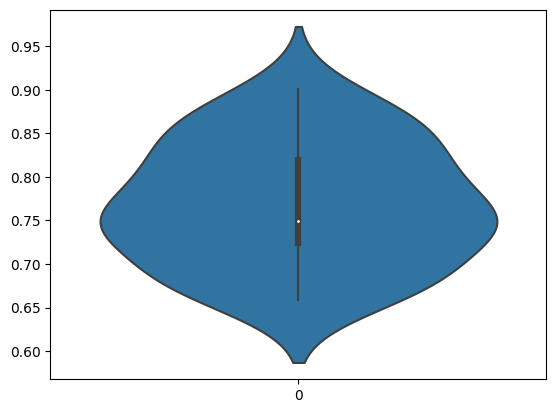

In [29]:
import seaborn as sns
sns.violinplot(data=dice_scores)

In [ ]:
# Put in image and show out/mask comparison

im, seg = next(iter(test_loader))

In [ ]:
im = im.to(device)
model.to(device)
out = model(im)

In [ ]:
out = out.detach().cpu()

In [ ]:
batch_dice_coeff(seg,out).item()

0.8352224230766296

(200, 256)


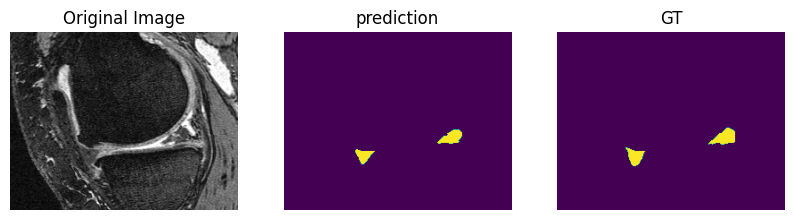

In [ ]:
import matplotlib.pyplot as plt

slice_num = 100

out = out[0][0].detach().cpu().numpy()
binary_mask = (out>0.5).astype(int)
image = im[0][0].detach().cpu().numpy()
gt = seg[0][0]

binary_slice = binary_mask[...,slice_num]
image = image[...,slice_num]
gt = gt[...,slice_num]

print(binary_slice.shape)

# Display the original image and the overlayed image using plt.imshow
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_slice)
ax[1].set_title('prediction')
ax[1].axis('off')

ax[2].imshow(gt)
ax[2].set_title('GT')
ax[2].axis('off')

plt.show()

In [ ]:
def show_mask_slices(img):
    num_subplots = 5
    plt.subplots(num_subplots, num_subplots, figsize = (num_subplots*4, num_subplots*4))

    for cnt, slnum in enumerate(range(0,img.shape[-1],img.shape[-1]//num_subplots**2)):

        if cnt < num_subplots**2:

            plt.subplot(num_subplots, num_subplots, cnt+1)
            plt.imshow(img[...,slnum], cmap = 'gray')
            plt.title('Slice {}'.format(slnum), fontsize= 20)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
seg[0][0].shape

torch.Size([200, 256, 160])

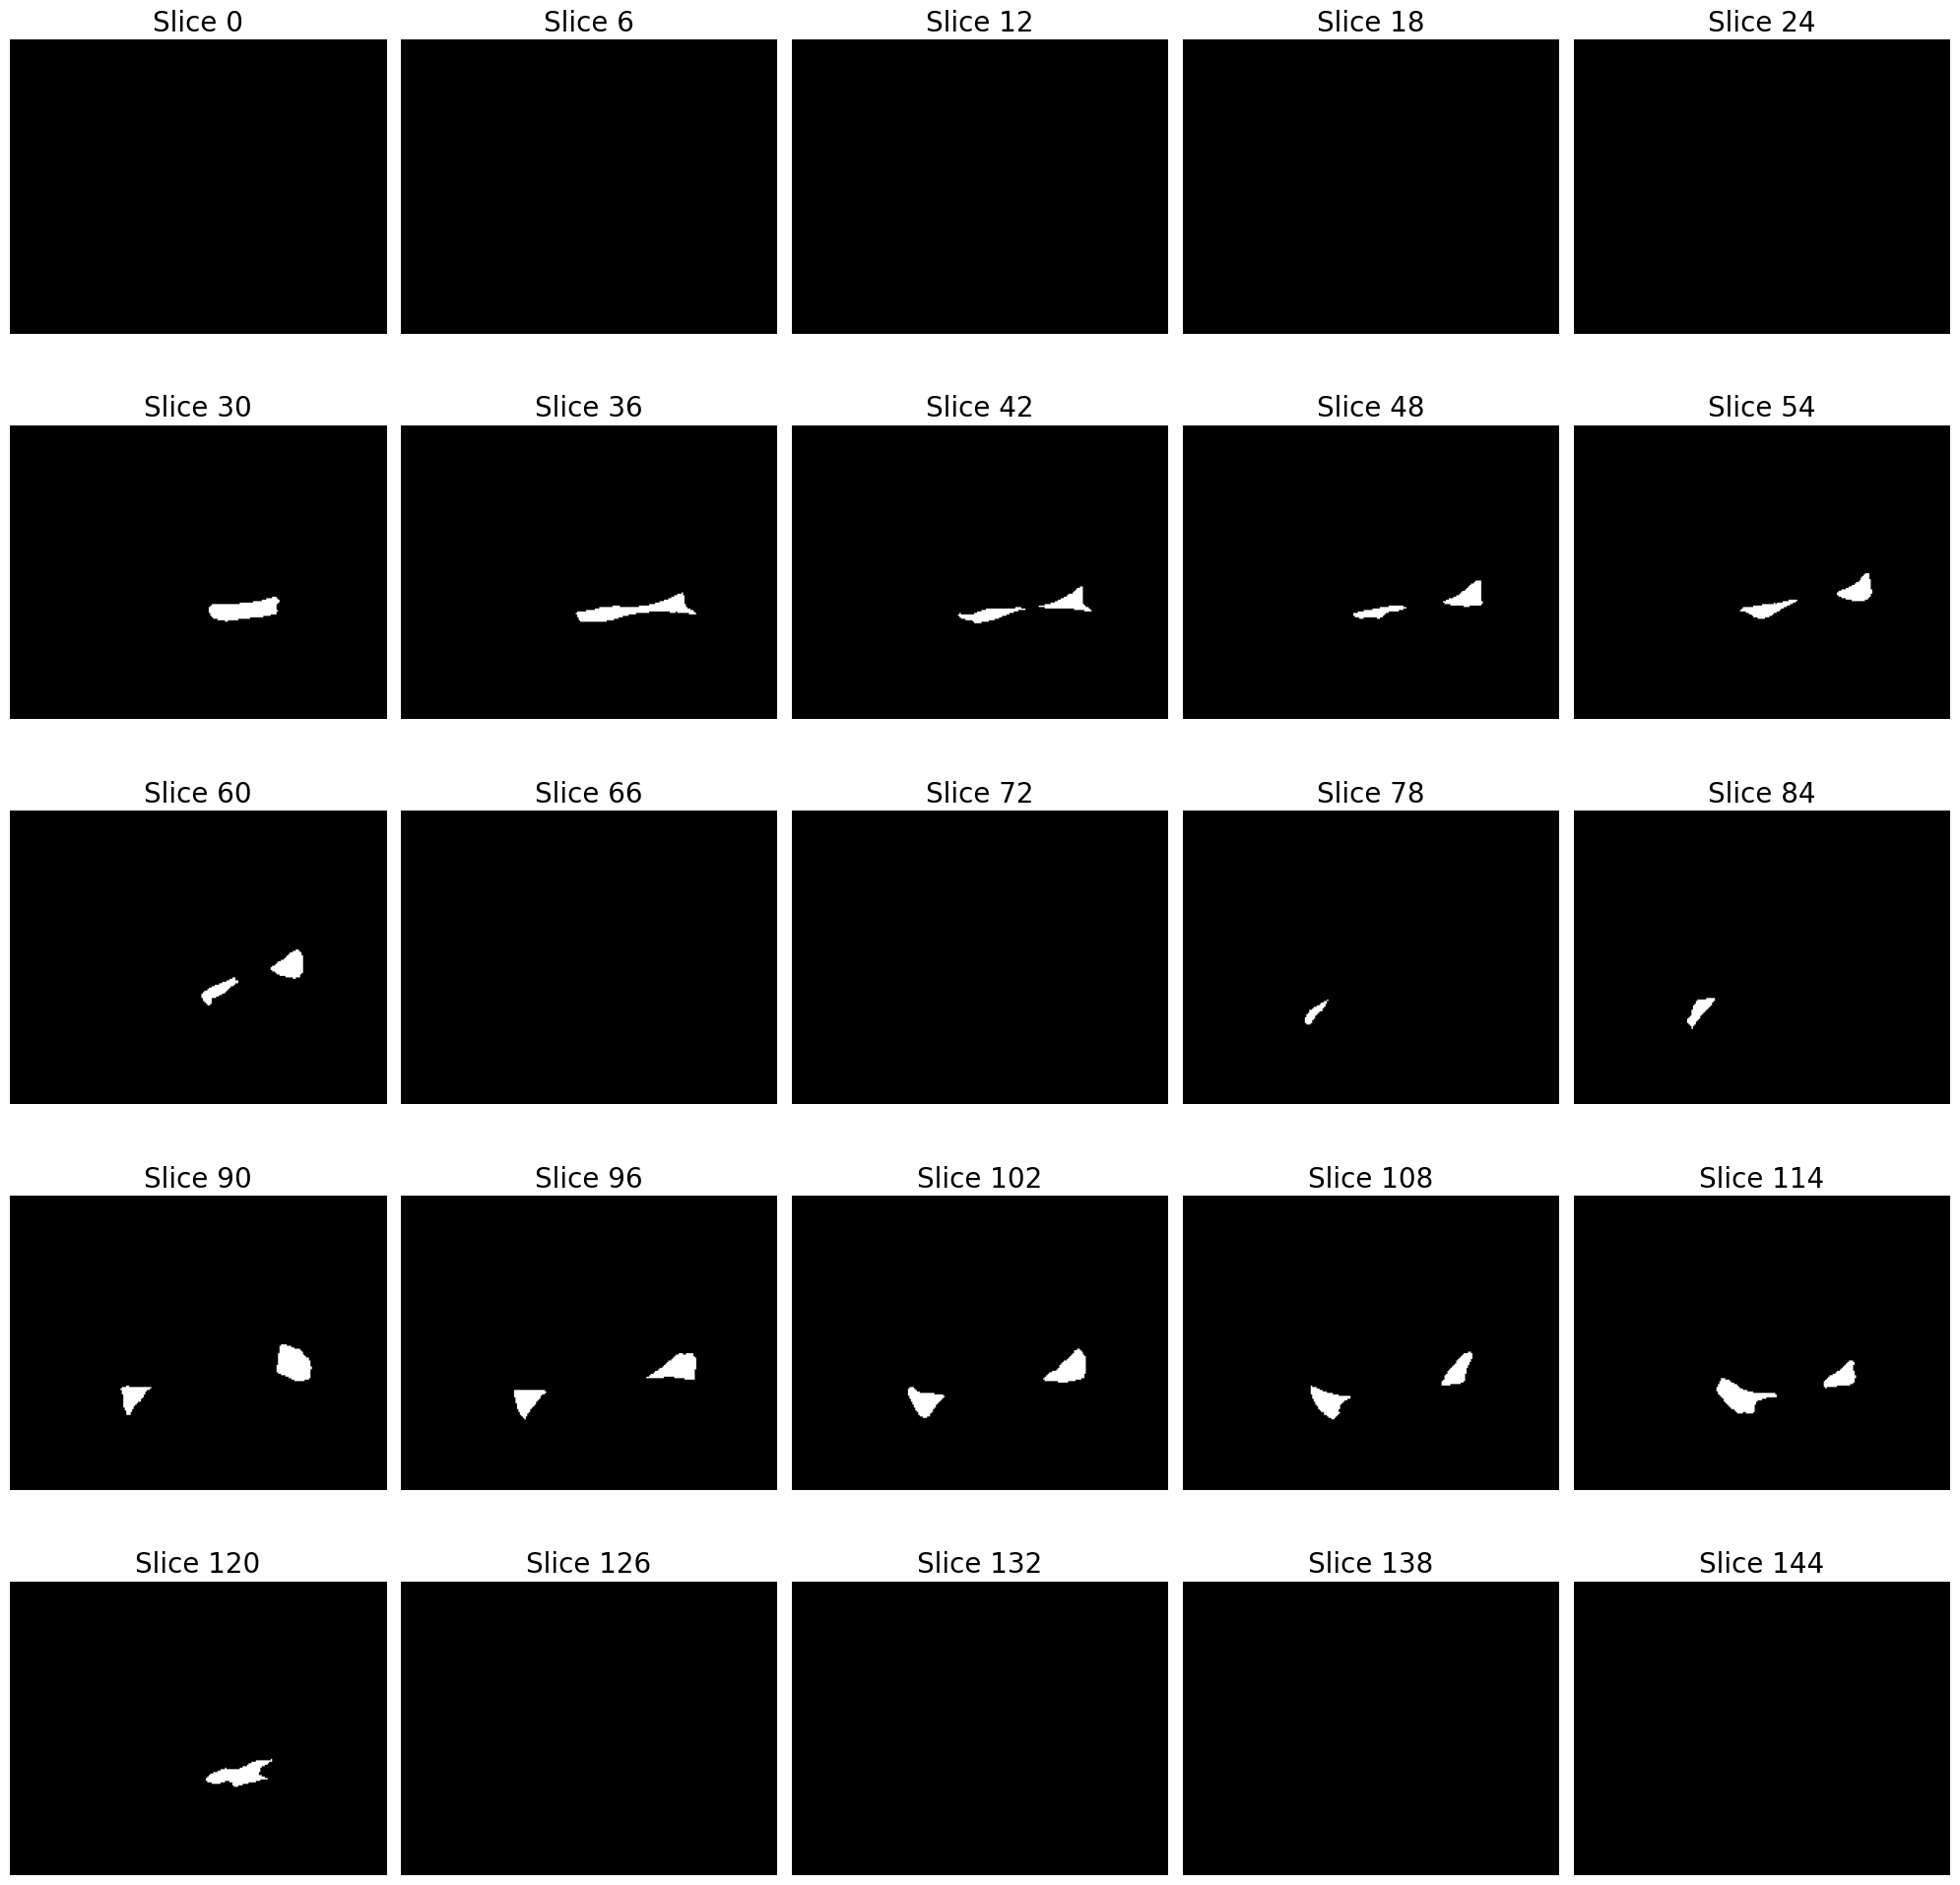

In [ ]:
show_mask_slices(seg[0][0])

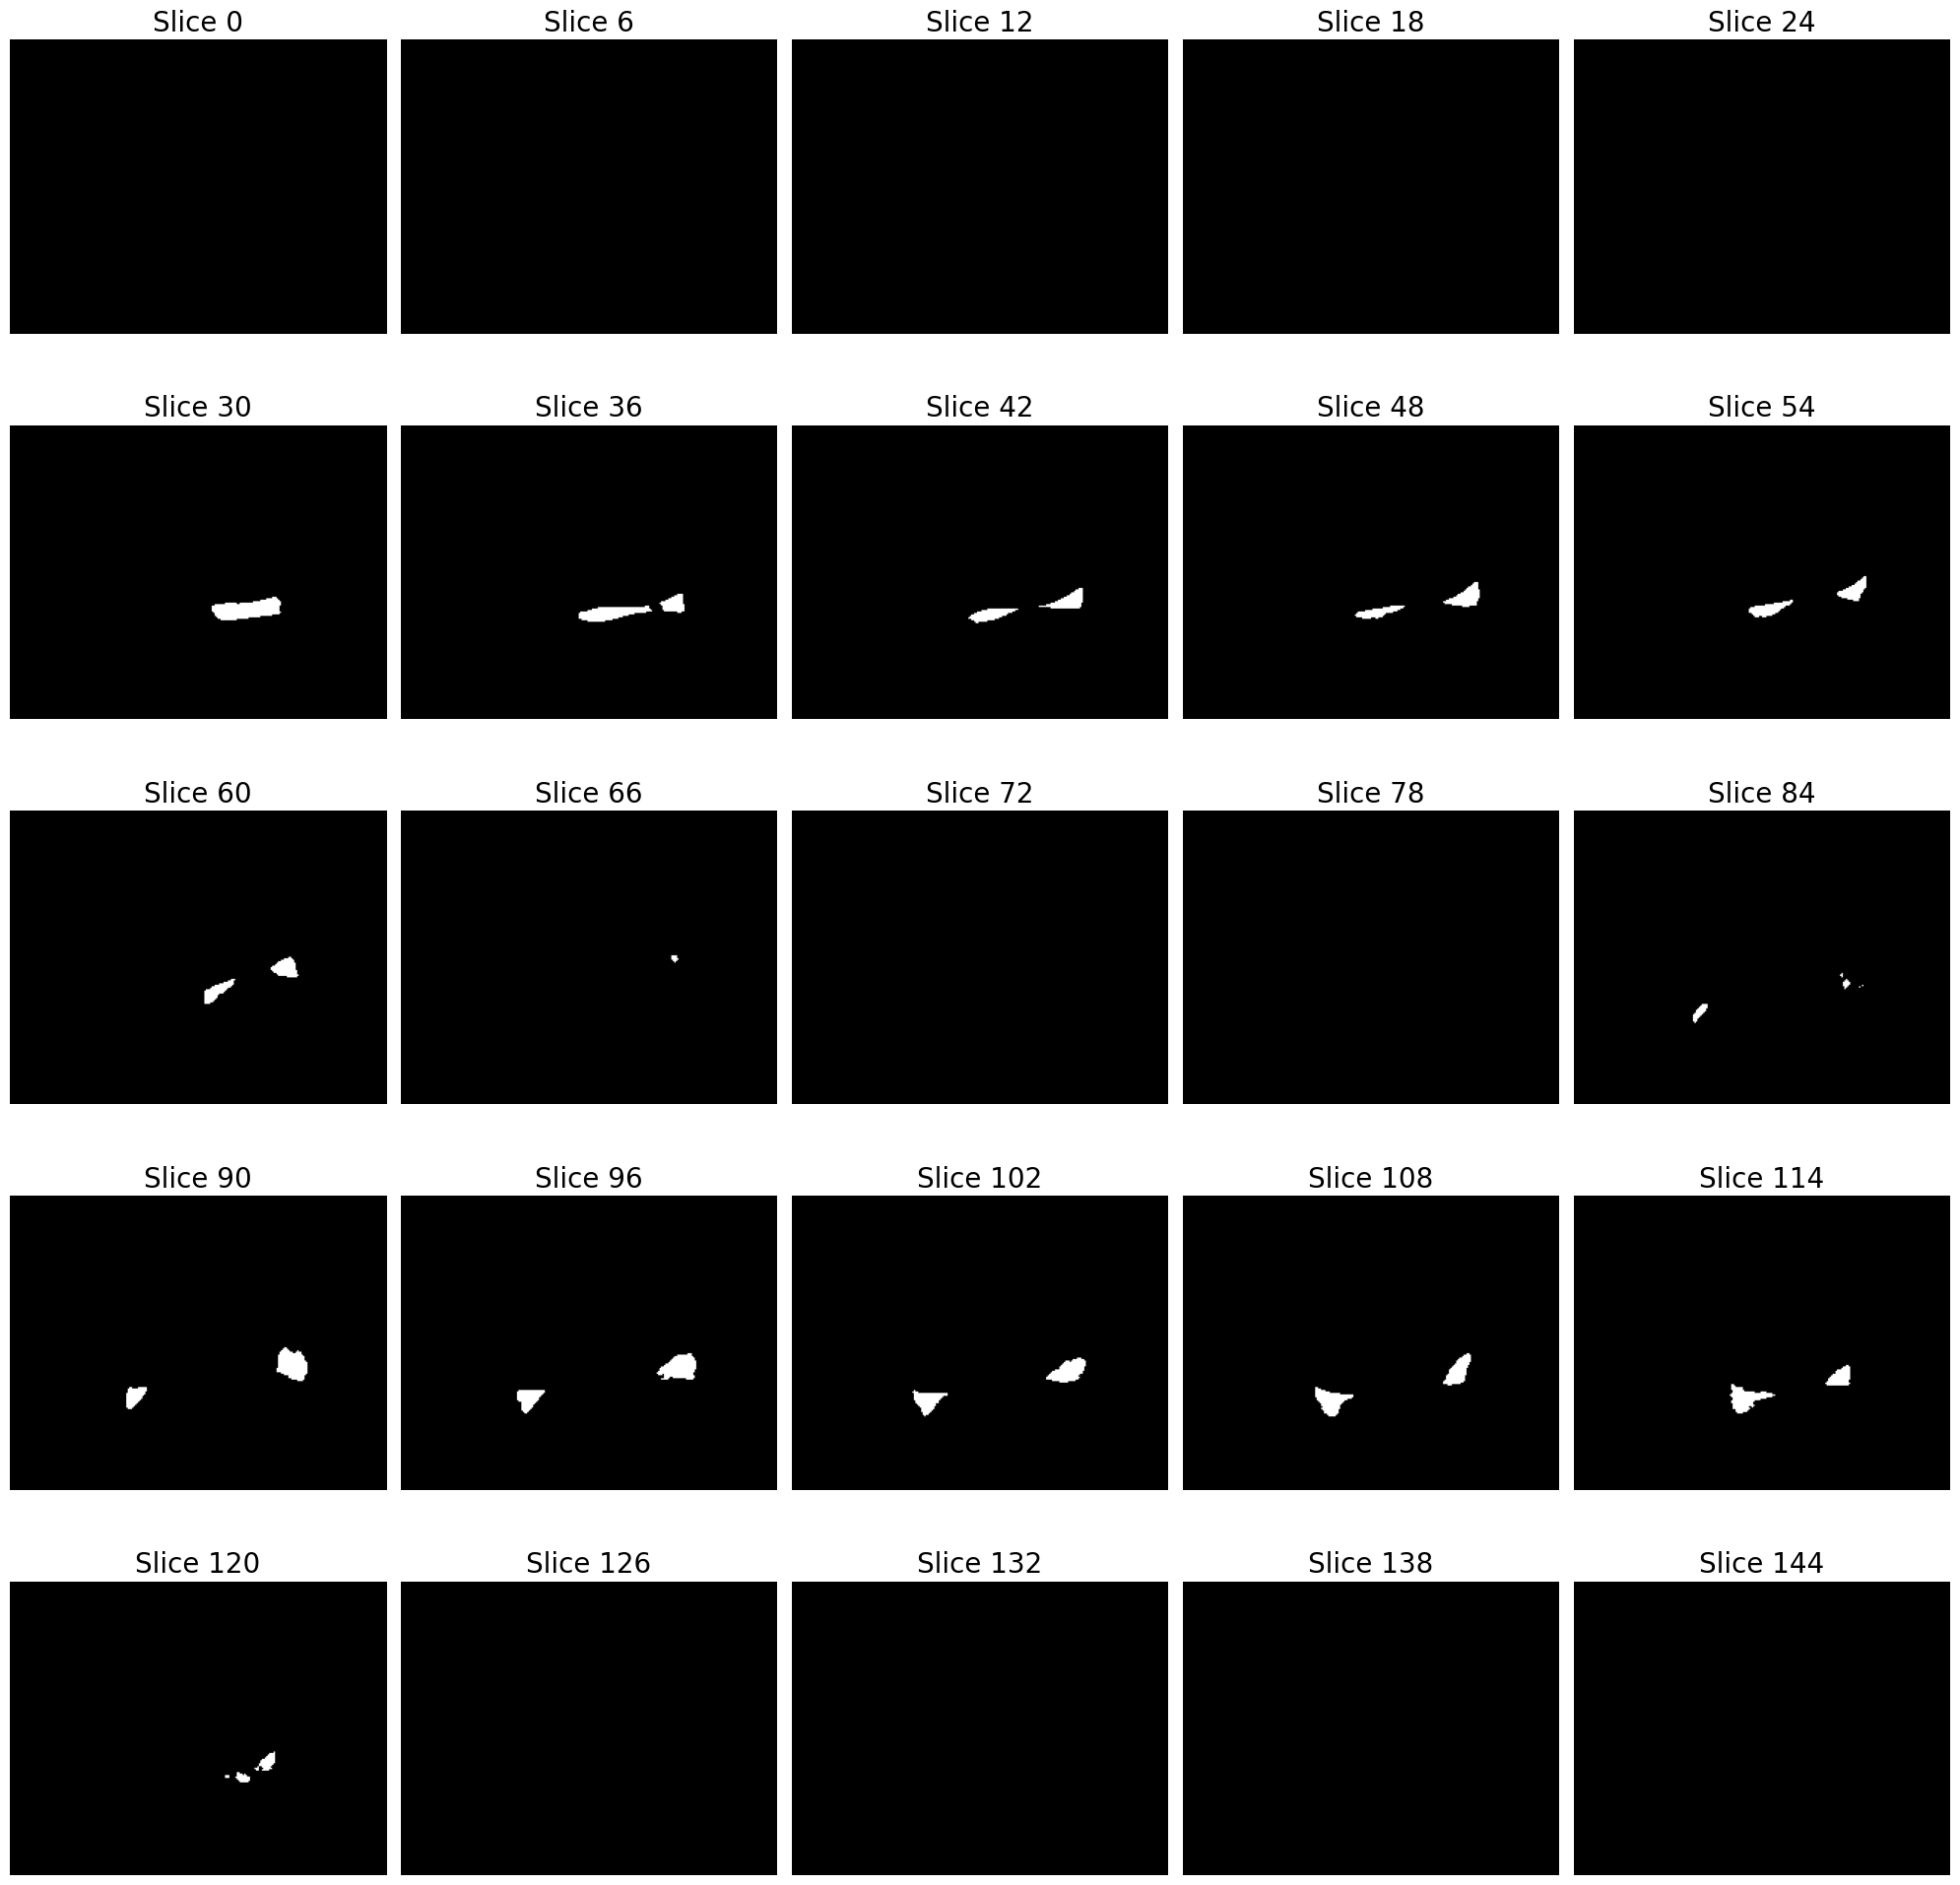

In [ ]:
show_mask_slices(binary_mask)

In [ ]:
seg[0][0].numpy().shape

(200, 256, 160)

In [ ]:
np.save(f'pred_mask_{val_paths[0]}', binary_mask)

In [ ]:
ground = seg[0][0].numpy()

In [ ]:
np.sum(ground.flatten())

39507.0

In [ ]:
np.sum(binary_mask.flatten())

31025

In [ ]:
# get volumes of all masks and predictions to see if it always underpredicts

from tqdm import tqdm

gt_volumes = []
pred_volumes = []
lowest_dice = 1
lowest_dice_idx = -1
count = 0

model.to(device)

for im, mask in tqdm(val_loader):
    im = im.to(device)
    out = model(im)
    out = out.detach().cpu()

    # store volumes of both gt and prediction
    gt_volumes.append(np.sum(mask[0][0].numpy().flatten()))
    pred_volumes.append(np.sum(out[0][0].numpy().flatten()))

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask, out)
    if dice < lowest_dice:
        lowest_dice = dice
        lowest_dice_idx = count

    # update count
    count += 1



100%|██████████| 28/28 [01:37<00:00,  3.49s/it]


In [ ]:
print(f"Lowest dice score in val set was image {lowest_dice_idx} with score {lowest_dice}")

Lowest dice score in val set was image 27 with score 0.8093818426132202


In [ ]:
print(f"image {lowest_dice_idx} has path {val_paths[lowest_dice_idx]}")

image 27 has path valid_014_V01
